<a href="https://colab.research.google.com/github/LCaravaggio/AnalisisCuantitativoAvanzado/blob/main/SeriesdeTiempo/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo ARIMA

La primera parte es toda igual.

Primero importamos todas las librerías necesarias, solo que esta vez incluimos la librería statsmodels

In [5]:
from google.colab import drive
import json

import requests
from requests.auth import HTTPBasicAuth

import pandas as pd

import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels

import matplotlib.pyplot as plt

In [6]:
from google.colab import userdata

# Definir user key para la API
user_key = userdata.get('ALPHACAST')

Obsérvese que tomamos la serie sin estacionalidad, en vez de la serie original.

In [7]:
# EMAE
emae = requests.get('https://api.alphacast.io/datasets/5331/data?apiKey='+user_key+'&&$format=csv', auth=HTTPBasicAuth(user_key, ''))
open('emae.csv','wb').write(emae.content)
emae = pd.read_csv('emae.csv',delimiter = ',')

emae['Date'] = pd.to_datetime(emae['Date'])
emae.set_index('Date', inplace = True)

emae = emae['Emae - sa_orig - current_prices_mom']
emae.columns = ['Emae - sa_orig - current_prices_mom']
emae = emae.loc['2016-02-01':]

In [8]:
# IPI
ipi = requests.get('https://api.alphacast.io/datasets/5679/data?apiKey='+user_key+'&&$format=csv', auth=HTTPBasicAuth(user_key, ''))
open('ipi.csv','wb').write(ipi.content)
ipi = pd.read_csv('ipi.csv',delimiter = ',')


ipi['Date'] = pd.to_datetime(ipi['Date'])
ipi.set_index('Date', inplace = True)
ipi = ipi[(ipi['Division'] == "IPI Manufacturero") & (ipi['Seasonal Adjustment'] == "Seasonally Adjusted")]
ipi = ipi['Value - current_prices_mom']
ipi.columns = ['Value - sa_MoM']
ipi = ipi.loc['2016-02-01':]

In [9]:
# ISAC
isac = requests.get('https://api.alphacast.io/datasets/5565/data?apiKey='+user_key+'&&$format=csv', auth=HTTPBasicAuth(user_key, ''))
open('isac.csv','wb').write(isac.content)
isac = pd.read_csv('isac.csv',delimiter = ',')


isac['Date'] = pd.to_datetime(isac['Date'])
isac.set_index('Date', inplace = True)
isac = isac['Nivel general - sa_orig - current_prices_mom']
isac.columns = ['Nivel general - sa_MoM']
isac = isac.loc['2016-02-01':]

Preparamos una función para graficar

In [10]:
sns.set_theme(style='darkgrid')
def graficar(variable):
    fig = sns.lineplot(x=variable.index, y=variable)
    plt.title(variable.name)
    plt.xlabel("Año")
    plt.savefig('%s.png'%variable.name)
    return fig

Y la graficamos. ¿Es estacionaria? No confundir estacional con estacionaria

<Axes: title={'center': 'Emae - sa_orig - current_prices_mom'}, xlabel='Año', ylabel='Emae - sa_orig - current_prices_mom'>

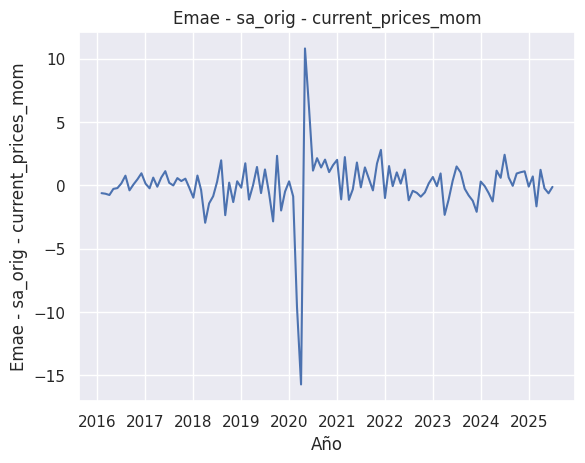

In [11]:
graficar(emae)

<Axes: title={'center': 'Value - current_prices_mom'}, xlabel='Año', ylabel='Value - current_prices_mom'>

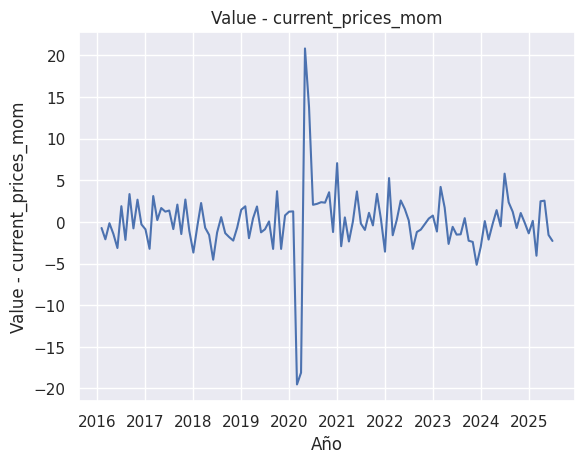

In [12]:
graficar(ipi)

<Axes: title={'center': 'Nivel general - sa_orig - current_prices_mom'}, xlabel='Año', ylabel='Nivel general - sa_orig - current_prices_mom'>

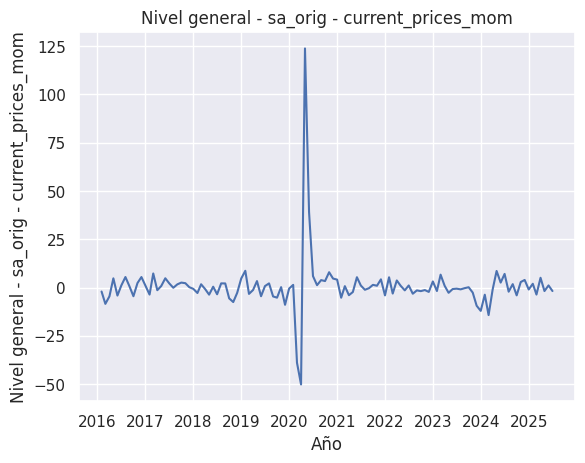

In [13]:
graficar(isac)

Chequeamos si la serie es estacionaria con el test de Dickey-Fuller aumentado del paquete Statsmodels.

La H0 del modelo es que la serie tiene raíz unitaria, es decir que no es estacionaria.

El p-value para los tres casos es <= 0.05 quiere decir que se puede rechazar la H0 y por tanto se asume que la serie es estacionaria. ¿Por qué? Ayuda: trajimos las series en diferencias.

In [14]:
from statsmodels.tsa.stattools import adfuller
res=adfuller(isac)
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('Critical Values:')
for key, value in res[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.468114
p-value: 0.000000
Critical Values:
	1%: -3.490
	5%: -2.888
	10%: -2.581


# Modelo simple con StatsModel

In [15]:
frame = { 'EMAE': emae, 'IPI': ipi , 'ISAC': isac}
df = pd.DataFrame(frame)

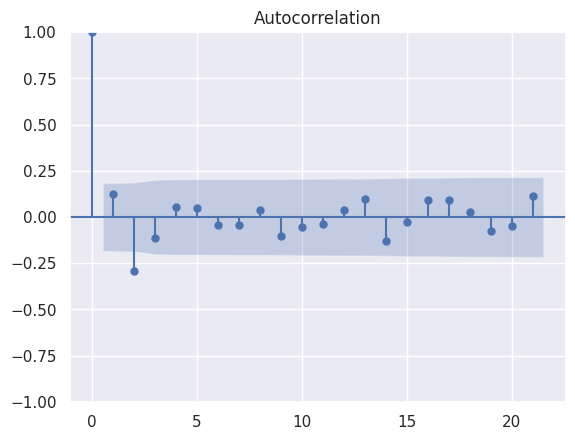

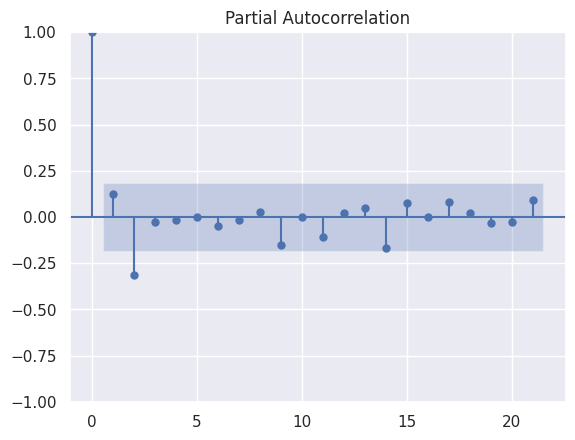

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['IPI'])
plt.show()

plot_pacf(df['IPI'])
plt.show()

In [17]:
results = smf.ols('EMAE ~ IPI + ISAC', data=df).fit()

In [18]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   EMAE   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     177.8
Date:                Thu, 25 Sep 2025   Prob (F-statistic):           2.44e-35
Time:                        18:37:09   Log-Likelihood:                -178.24
No. Observations:                 114   AIC:                             362.5
Df Residuals:                     111   BIC:                             370.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0387      0.110      0.351      0.7

In [19]:
X =  pd.DataFrame({'IPI': [df['IPI'][-1]], 'ISAC': [df['ISAC'][-1]]})

/tmp/ipython-input-3065900665.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X =  pd.DataFrame({'IPI': [df['IPI'][-1]], 'ISAC': [df['ISAC'][-1]]})


In [20]:
X

,IPI,ISAC
0,-2.29136,-1.817049


In [21]:
print(results.predict(X)[0])

-0.9331659695787359


In [22]:
df[-5:]

,EMAE,IPI,ISAC
Date,,,
2025-03-01,-1.668469,-4.063489,-3.636319
2025-04-01,1.215458,2.474633,5.052270
2025-05-01,-0.244393,2.545213,-1.821139
2025-06-01,-0.636894,-1.567371,1.090691
2025-07-01,-0.131911,-2.291360,-1.817049


# Modelo ARIMA

In [23]:
from statsmodels.tsa.arima.model import ARIMA

In [24]:
df.EMAE[:-1]

,EMAE
Date,
2016-02-01,-0.627192
2016-03-01,-0.670262
2016-04-01,-0.771878
2016-05-01,-0.290096
2016-06-01,-0.225846
...,...
2025-02-01,0.693352
2025-03-01,-1.668469
2025-04-01,1.215458


In [25]:
mod = ARIMA(df.EMAE , order=(1, 0, 1))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   EMAE   No. Observations:                  114
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -255.766
Date:                Thu, 25 Sep 2025   AIC                            519.532
Time:                        18:37:09   BIC                            530.477
Sample:                    02-01-2016   HQIC                           523.974
                         - 07-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0469      0.290      0.162      0.872      -0.522       0.615
ar.L1         -0.8213      0.058    -14.234      0.000      -0.934      -0.708
ma.L1          1.0000     17.504      0.057      0.9

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


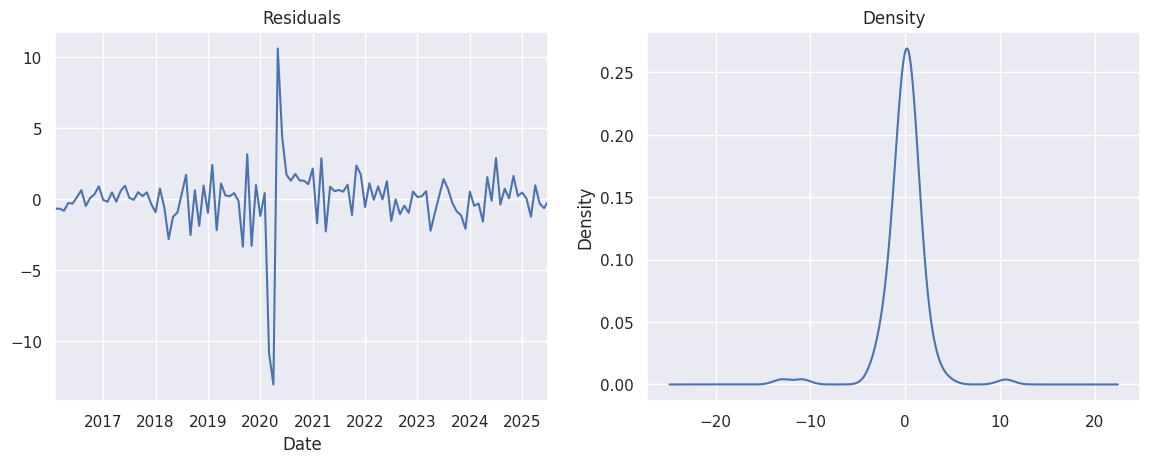

In [26]:
import matplotlib.pyplot as plt
residuals = res.resid

fig, ax = plt.subplots(1,2)
fig.set_figwidth(14)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

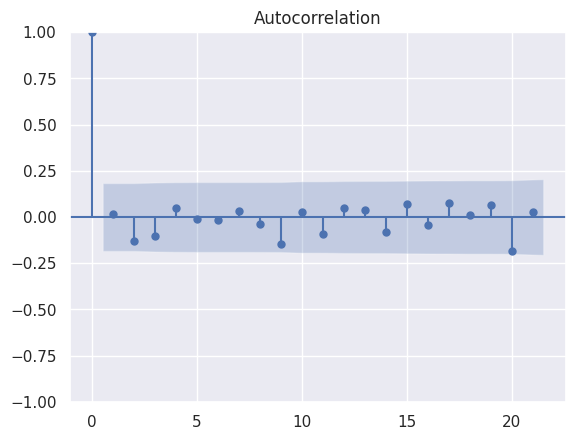

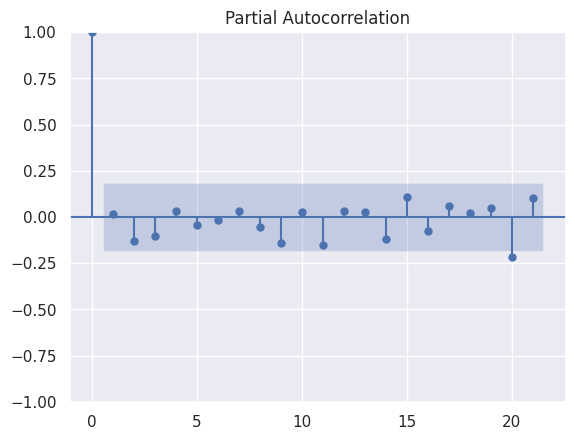

In [27]:
plot_acf(residuals)
plt.show()

plot_pacf(residuals)
plt.show()

# Predicción

In [28]:
X = df['EMAE'].loc['2016-02-01':]
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [29]:
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(1,0,1))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))

/tmp/ipython-input-3762364750.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test[t]


predicted=-0.017569, expected=-0.279184
predicted=0.054133, expected=-0.804656
predicted=-0.125359, expected=-1.224830
predicted=-0.046078, expected=-2.099669
predicted=-0.320754, expected=0.288602
predicted=0.376435, expected=-0.080066
predicted=-0.378445, expected=-0.610023
predicted=0.264328, expected=-1.281464
predicted=-0.510938, expected=1.147568
predicted=0.689115, expected=0.584992
predicted=-0.577558, expected=2.406748
predicted=0.997272, expected=0.617217
predicted=-0.822410, expected=-0.049027
predicted=0.431382, expected=0.923805
predicted=-0.623693, expected=1.027795
predicted=0.286820, expected=1.097804
predicted=0.031464, expected=-0.111061
predicted=0.646993, expected=0.693352
predicted=-0.417565, expected=-1.668469
predicted=0.235779, expected=1.215458
predicted=0.067526, expected=-0.244393
predicted=-0.007078, expected=-0.636894
predicted=-0.008344, expected=-0.131911


In [30]:
from math import sqrt
from sklearn.metrics import mean_squared_error
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.110


In [31]:
import numpy as np
df['prediction'] = np.nan
df.iloc[-len(predictions):, df.columns.get_loc('prediction')] = predictions

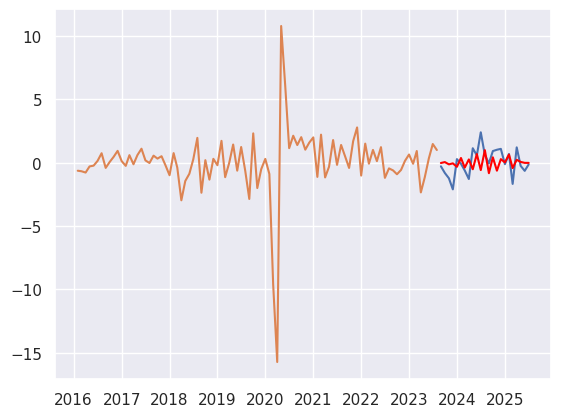

In [32]:
from matplotlib import pyplot
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(train)
pyplot.plot(df['prediction'], color='red')
pyplot.show()

# Auto ARIMA

In [34]:
import itertools
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

def auto_arima_statsmodels(y, p_range=3, d_range=2, q_range=3):
    """Busca automáticamente el mejor (p,d,q) usando AIC"""
    best_aic = float("inf")
    best_order = None
    best_model = None

    for p,d,q in itertools.product(range(p_range+1), range(d_range+1), range(q_range+1)):
        try:
            model = ARIMA(y, order=(p,d,q)).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = (p,d,q)
                best_model = model
        except:
            continue

    return best_model, best_order

# Uso:
best_model, best_order = auto_arima_statsmodels(df.EMAE)
print(f"Mejor orden ARIMA: {best_order}, AIC: {best_model.aic}")

Mejor orden ARIMA: (2, 0, 2), AIC: 519.1390908198512
